In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pysentani
import sentani as sti

In [2]:
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')

In [3]:
survey['access_type'] = pysentani.access_type(survey)

In [4]:
# selects only demand points that are households to use for analysis
household_survey = survey[survey['demand_point'] == 'household']

# creates variable of number of households per village
hh_series = pd.value_counts(household_survey['village_name'])
# creates list of household count per village
hh_ls = list(hh_series)

# crosstab between working and non working genset
pd.crosstab(household_survey['power_supply/private_genset'],household_survey['power_supply_working/private_genset'])
# count of working gensets by village
go_df = household_survey.groupby(['village_name'])[['power_supply_working/private_genset']].agg(['count'])

# assigns access type to each village
access_dict = household_survey.set_index('village_name')['access_type'].to_dict()
#creates variable that returns access type
access_ls = list(access_dict.values())
# creates variable that returns village name
village_ls = list(access_dict.keys())
# essentially the same as go_df (above) (will need some help with why this is necessary)
go_series = go_df['power_supply_working/private_genset']['count']

# caclulates percent of households with working genset by village
percentage_ownership_series = (go_series/hh_series)*100

# renames created variables for use in data frame
po_dict = {'households': hh_ls, 'access_type':access_ls,'village':village_ls}
# creates dataframe with all of the variables above in order to perform a function (below)
po_df = pd.DataFrame(po_dict)
po_df

# separates households into either access or no access by taking points that have any kind of
# grid access and simply classifying them as having "access"
def elec_access(df):
    if df['access_type'] == 'no_access':
        access = "No Access"
    else:
        access = "Access"
    
    return access

# applies above function (elec_access) to po_df dataframe
po_df['access'] = po_df.apply(elec_access, axis = 1)
# applies above function to all demand points that are households (not sure this is necessary)
household_survey['access'] = household_survey.apply(elec_access, axis = 1)
po_df

# creates variable with count of households that are either access or no access
ownership_survey = pd.DataFrame.from_dict(data = po_df.groupby('access')
                                          ['households'].sum().to_dict(), orient ='index')

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# all of this needs descriptive text. work pending...

app_series1 = ['app_buy/rice_cooker','app_buy/fridge','app_buy/fan','app_buy/radio','app_buy/TV','app_buy/lighting']


pao_ls = []

for aps in app_series1:
    
    app_now = 'app_now' + aps[7:]  
    
    temp_app_now_df = pd.crosstab(household_survey['access'],household_survey[app_now])
    temp_app_buy_df = pd.crosstab(household_survey[household_survey[app_now] == False]['access'],household_survey[aps])
    
    ownership_df = pd.DataFrame.from_dict(data = temp_app_now_df[1.0].to_dict(), orient ='index')
    column_name_own = 'households_own_' + aps[8:]
    ownership_survey[column_name_own] = ownership_df[0]
    
    desire_df = pd.DataFrame.from_dict(data = temp_app_buy_df[1.0].to_dict(), orient ='index')
    column_name_want = 'households_want_' + aps[8:]
    ownership_survey[column_name_want] = desire_df[0]

ownership_survey['access'] = list(ownership_survey.index)

In [6]:
if 0 in list(ownership_survey.columns):
    ownership_survey.rename(columns={0:'total_households'}, inplace=True)

In [7]:
# all of this needs descriptive text. work pending...

app_series2 = ['rice_cooker','fridge','fan','radio','lighting','TV']
access_series = ['No Access','Access']

na_ownership_survey = ownership_survey[ownership_survey['access'] == 'No Access']
a_ownership_survey = ownership_survey[ownership_survey['access'] == 'Access']

na_dict = {}
a_dict = {}

df_ls = []

for aps in app_series2:
    
    own = 'households_own_' + aps
    want = 'households_want_' + aps
    app_key = 'projected_ownership_' + aps
    
    projected_po_na = (((na_ownership_survey[own] + na_ownership_survey[want])/na_ownership_survey['total_households']) * 100)['No Access']
    
    existing_po_a = ((a_ownership_survey[own] / a_ownership_survey['total_households']) * 100)['Access']
    
    for acs in access_series:
        if acs == 'No Access':
            na_dict.update({'access':'No Access', app_key: projected_po_na})
        else:
            a_dict.update({'access': 'Access', app_key: existing_po_a})

            
df_ls.append(na_dict)
df_ls.append(a_dict)
df = pd.DataFrame(df_ls)  

In [8]:
ppo_df = pd.melt(df, id_vars=['access'], value_vars=['projected_ownership_fan',
                                                     'projected_ownership_fridge',
                                                     'projected_ownership_radio',
                                                     'projected_ownership_rice_cooker',
                                                     'projected_ownership_lighting',
                                                     'projected_ownership_TV'])

(0, 100)

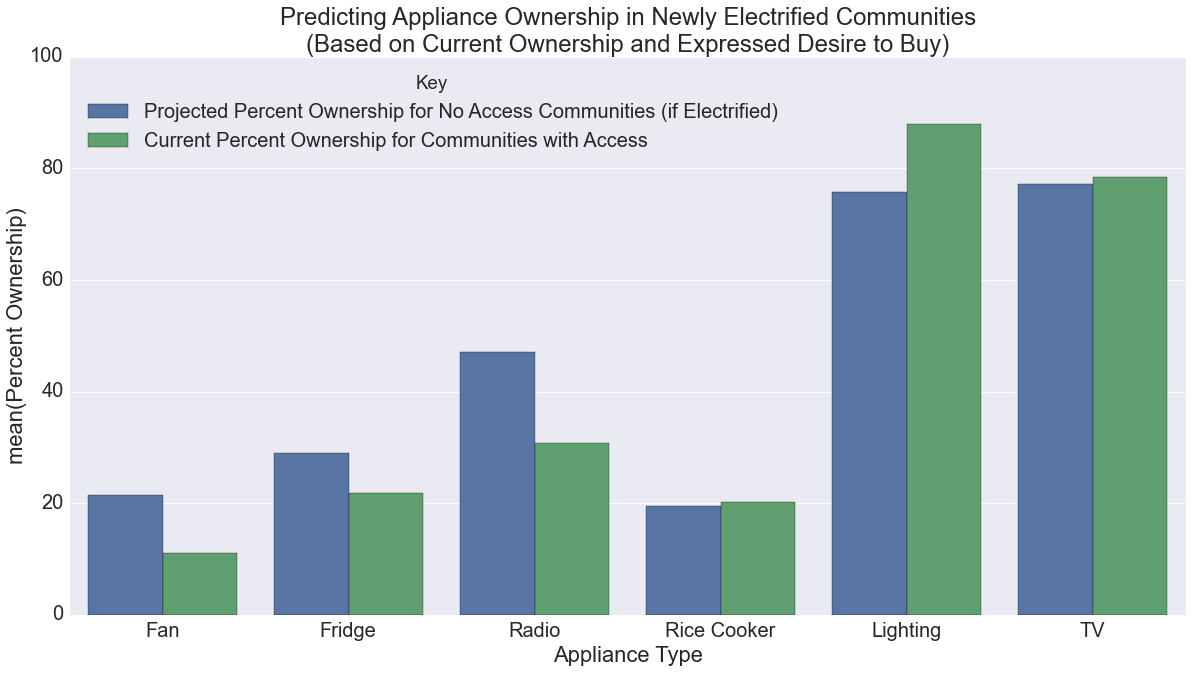

In [9]:
ppo_df.replace(to_replace = {'variable': {'projected_ownership_fan': 'Fan',
                                          'projected_ownership_fridge': 'Fridge',
                                          'projected_ownership_radio': 'Radio',
                                          'projected_ownership_rice_cooker': 'Rice Cooker',
                                          'projected_ownership_lighting': 'Lighting',
                                          'projected_ownership_TV': 'TV'},
                             'access': {'No Access': 'Projected Percent Ownership for No Access Communities (if Electrified)',
                                        'Access': 'Current Percent Ownership for Communities with Access' }},
                                        inplace = True)

ppo_df.rename(columns={'variable': 'Appliance',
                       'value': 'Percent Ownership',
                       'access': 'Key'},
                       inplace = True)

sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="Appliance", y="Percent Ownership", hue="Key", data=ppo_df)


ax.set(xlabel='Appliance Type',title = 'Predicting Appliance Ownership in Newly Electrified Communities\n(Based on Current Ownership and Expressed Desire to Buy)')

plt.ylim(0,100)

#fig.savefig('test.pdf')
 

In [10]:
ppo_df

,Key,Appliance,Percent Ownership
0,Projected Percent Ownership for No Access Comm...,Fan,21.501706
1,Current Percent Ownership for Communities with...,Fan,11.067708
2,Projected Percent Ownership for No Access Comm...,Fridge,29.010239
3,Current Percent Ownership for Communities with...,Fridge,21.875000
4,Projected Percent Ownership for No Access Comm...,Radio,47.098976
5,Current Percent Ownership for Communities with...,Radio,30.859375
6,Projected Percent Ownership for No Access Comm...,Rice Cooker,19.453925
7,Current Percent Ownership for Communities with...,Rice Cooker,20.182292
8,Projected Percent Ownership for No Access Comm...,Lighting,75.767918
9,Current Percent Ownership for Communities with...,Lighting,88.020833


# Details of Created Variables Above

In [11]:
hh_series

Ayapo           113
Sosiri           94
Flafow           68
Puai             67
Babrongko        59
Yakonde          57
Simporo          54
Yoboi            46
Donday           43
Yokiwa           38
Abar             38
Atamali          34
Kampung_Baru     33
Ebunfauw         30
Yobeh            28
Kwadeware        28
Yoka             27
Kalio            27
Asei             25
Kheleubulow      23
Evale            22
Hobong           19
Kensio           18
Khageuw          16
Ajau             14
Pantai_Yahim     13
Khamayakha       12
Obolyo           10
Burawai           5
dtype: int64

In [12]:
hh_ls

[113,
 94,
 68,
 67,
 59,
 57,
 54,
 46,
 43,
 38,
 38,
 34,
 33,
 30,
 28,
 28,
 27,
 27,
 25,
 23,
 22,
 19,
 18,
 16,
 14,
 13,
 12,
 10,
 5]

In [13]:
pd.crosstab(household_survey['power_supply/private_genset'],household_survey['power_supply_working/private_genset'])

power_supply_working/private_genset,0.0,1.0
power_supply/private_genset,,
0,735,19
1,9,210


In [14]:
go_df

,power_supply_working/private_genset
,count
village_name,
Abar,23
Ajau,12
Asei,24
Atamali,34
Ayapo,112
Babrongko,59
Burawai,5
Donday,42


In [15]:
access_dict

{'Abar': 'no_access',
 'Ajau': 'PLN_grid',
 'Asei': 'PLN_grid',
 'Atamali': 'community_microgrid',
 'Ayapo': 'PLN_microgrid',
 'Babrongko': 'PLN_grid',
 'Burawai': 'PLN_grid',
 'Donday': 'PLN_microgrid',
 'Ebunfauw': 'no_access',
 'Evale': 'PLN_grid',
 'Flafow': 'PLN_grid',
 'Hobong': 'PLN_grid',
 'Kalio': 'no_access',
 'Kampung_Baru': 'no_access',
 'Kensio': 'community_microgrid',
 'Khageuw': 'no_access',
 'Khamayakha': 'PLN_grid',
 'Kheleubulow': 'PLN_grid',
 'Kwadeware': 'PLN_grid',
 'Obolyo': 'no_access',
 'Pantai_Yahim': 'PLN_grid',
 'Puai': 'no_access',
 'Simporo': 'PLN_grid',
 'Sosiri': 'PLN_grid',
 'Yakonde': 'PLN_grid',
 'Yobeh': 'PLN_grid',
 'Yoboi': 'no_access',
 'Yoka': 'PLN_grid',
 'Yokiwa': 'no_access'}

In [16]:
access_ls

['PLN_grid',
 'no_access',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'no_access',
 'no_access',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'community_microgrid',
 'PLN_microgrid',
 'PLN_grid',
 'no_access',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'PLN_grid',
 'no_access',
 'PLN_grid',
 'no_access',
 'no_access',
 'PLN_grid',
 'community_microgrid',
 'PLN_microgrid',
 'no_access',
 'no_access']

In [17]:
village_ls

['Ajau',
 'Kampung_Baru',
 'Simporo',
 'Pantai_Yahim',
 'Yobeh',
 'Evale',
 'Kalio',
 'Ebunfauw',
 'Hobong',
 'Kwadeware',
 'Kheleubulow',
 'Yoka',
 'Kensio',
 'Donday',
 'Asei',
 'Khageuw',
 'Babrongko',
 'Flafow',
 'Khamayakha',
 'Yakonde',
 'Yoboi',
 'Burawai',
 'Obolyo',
 'Puai',
 'Sosiri',
 'Atamali',
 'Ayapo',
 'Yokiwa',
 'Abar']

In [18]:
go_series

village_name
Abar             23
Ajau             12
Asei             24
Atamali          34
Ayapo           112
Babrongko        59
Burawai           5
Donday           42
Ebunfauw         30
Evale            21
Flafow           68
Hobong           19
Kalio            13
Kampung_Baru     31
Kensio           16
Khageuw           9
Khamayakha       11
Kheleubulow      23
Kwadeware        28
Obolyo            0
Pantai_Yahim     13
Puai             63
Simporo          54
Sosiri           93
Yakonde          53
Yobeh            27
Yoboi            29
Yoka             27
Yokiwa           36
Name: count, dtype: int64

In [20]:
percentage_ownership_series

Abar             60.526316
Ajau             85.714286
Asei             96.000000
Atamali         100.000000
Ayapo            99.115044
Babrongko       100.000000
Burawai         100.000000
Donday           97.674419
Ebunfauw        100.000000
Evale            95.454545
Flafow          100.000000
Hobong          100.000000
Kalio            48.148148
Kampung_Baru     93.939394
Kensio           88.888889
Khageuw          56.250000
Khamayakha       91.666667
Kheleubulow     100.000000
Kwadeware       100.000000
Obolyo            0.000000
Pantai_Yahim    100.000000
Puai             94.029851
Simporo         100.000000
Sosiri           98.936170
Yakonde          92.982456
Yobeh            96.428571
Yoboi            63.043478
Yoka            100.000000
Yokiwa           94.736842
dtype: float64

In [21]:
po_df

,access_type,households,village,access
0,PLN_grid,113,Ajau,Access
1,no_access,94,Kampung_Baru,No Access
2,PLN_grid,68,Simporo,Access
3,PLN_grid,67,Pantai_Yahim,Access
4,PLN_grid,59,Yobeh,Access
5,PLN_grid,57,Evale,Access
6,no_access,54,Kalio,No Access
7,no_access,46,Ebunfauw,No Access
8,PLN_grid,43,Hobong,Access
9,PLN_grid,38,Kwadeware,Access


In [22]:
ownership_survey

,total_households,households_own_rice_cooker,households_want_rice_cooker,households_own_fridge,households_want_fridge,households_own_fan,households_want_fan,households_own_radio,households_want_radio,households_own_TV,households_want_TV,households_own_lighting,households_want_lighting,access
Access,768,155,127,168,240,85,86,237,33,602,74,676,4,Access
No Access,293,8,49,4,81,20,43,110,28,201,25,221,1,No Access
